# COPD CHALLENGE MIRA FINAL PROJECT
MAIA 2021 -2023

Made by:
- Juan Cisneros
- Karla Sam

# Project Description

The goal of this analysis is to generate algorithms to accurately register intrapatient exhale and inhale lung CTs from the 4DCT DIR-Lab challenge Datasets.

#Initializing

## Libraries

In [ ]:
!pip install SimpleITK-SimpleElastix
!pip install connected-components-3d
!pip install ipython-autotime
%load_ext autotime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 56.5 MB 1.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.8 MB 7.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 8.5 MB/s 
time: 439 µs (started: 2022-12-20 09:27:15 +00:00)


In [ ]:
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import SimpleITK as sitk
import cc3d
from skimage import exposure

time: 1.05 s (started: 2022-12-20 09:27:15 +00:00)


## Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
time: 26.8 s (started: 2022-12-20 09:27:16 +00:00)


## Files path

In [ ]:
project_path = '/content/drive/MyDrive/MIRA Project/'

time: 1.3 ms (started: 2022-12-20 09:27:43 +00:00)


# Functions

### Txt to numpy array

In [ ]:
def txt_to_np(patient_num, file_name):
    """
    txt_to_np converts the points txt file from the Drive folder into csv files,
    saves them in the same folder, and then converts it into np an array.

    :param patient_num: the number of the patient
    :param file_name: the name of the txt file with the points
    :return: the inhale and exhale arrays of that patient
    """
    # Converting from txt to csv
    patient_num = str(patient_num)
    read_file = pd.read_csv(project_path + f'copd{patient_num}/{file_name}.txt', sep='\s+', header=None)
    read_file.to_csv(project_path + f'copd{patient_num}/{file_name}.csv', header=None)

    # Converting to df
    columns = ['x','y','z']
    df = pd.read_csv(project_path + f'copd{patient_num}/{file_name}.csv', header=None, names=columns)

    # Converting to np
    array = df.to_numpy()

    return array

time: 4.23 ms (started: 2022-12-20 09:27:43 +00:00)


### Compute the distance

In [ ]:
def distance(array_i, array_e, xy_spacing, z_spacing):
    """
    distance computes the mean distance and the std between the inhale and
    exhale points in the two specified arrays.

    :param array_i: the array of points from the inhale image
    :param array_e: the array of points from the exhale image
    :param xy_spacing: the x and y pixel spacing
    :param z_spaicing: the z pixel spacing
    :return: the average distance of the points
    """
    ## Inhale array with spacing
    array_spacing_i = np.zeros_like(array_i, dtype=float)
    array_spacing_i[:, 0] = array_i[:, 0] * xy_spacing
    array_spacing_i[:, 1] = array_i[:, 1] * xy_spacing
    array_spacing_i[:, 2] = array_i[:, 2] * z_spacing

    ## Exhale array with spacing
    array_spacing_e = np.zeros_like(array_e, dtype=float)
    array_spacing_e[:, 0] = array_e[:, 0] * xy_spacing
    array_spacing_e[:, 1] = array_e[:, 1] * xy_spacing
    array_spacing_e[:, 2] = array_e[:, 2] * z_spacing

    ## Compute the avg distance
    dist = np.sqrt(np.sum(np.square(array_spacing_e - array_spacing_i), axis=1))
    avg_dist = np.mean(dist)
    std_dist = np.std(dist)

    return avg_dist, std_dist

time: 6.34 ms (started: 2022-12-20 09:27:43 +00:00)


### Lung segmentation (no connected components)

In [ ]:
def lung_seg(lung_np):
    """
    lung_seg segments the lungs with thresholding and morphological operations

    :param exhale_np: the numpy array with the lung image
    :return: the lung mask np array
    """
    lung_np_copy = lung_np.copy()

    ## Normalizing the image to 0-255 and changing datatype
    lung_np_copy[lung_np_copy == -2000] = 0
    norm_img = np.zeros((800,800))
    lung_norm = cv.normalize(lung_np_copy,  norm_img, 0, 255, cv.NORM_MINMAX)
    lung_norm = lung_norm.astype("uint8")

    ## Creating empty volumes for saving processed slices
    lung_mask = np.zeros_like(lung_np)

    ## Loop for processing each slice
    for i in range(lung_np_copy.shape[0]):

        ## Getting a single slice of the image
        lung_slice = lung_norm[i,:,:]

        ## Blurring and thresholding
        lung_blurred = cv.GaussianBlur(lung_slice, (19,19), 0)
        lung_thresh = cv.threshold(lung_blurred, 0, 255, cv.THRESH_BINARY_INV | cv.THRESH_OTSU)[1]

        ## Morphological operations
        kernel1 = np.ones((9,9),np.uint8)
        kernel2 = np.ones((5,5),np.uint8)
        lung_close = cv.morphologyEx(lung_thresh, cv.MORPH_CLOSE, kernel1)
        lung_open = cv.morphologyEx(lung_close, cv.MORPH_OPEN, kernel2)
        lung_blurred_med = cv.medianBlur(lung_open, 11)
        lung_dilate = cv.morphologyEx(lung_blurred_med, cv.MORPH_DILATE, kernel1)

        ## Getting rid of background
        if lung_dilate[0, 0] == 255: # Check exhale top left corner
            cv.floodFill(lung_dilate, None, seedPoint=(0, 0), newVal=0, loDiff=3, upDiff=3)
        if lung_dilate[-1, -1] == 255: # Check exhale bottom right corner
            cv.floodFill(lung_dilate, None, seedPoint=(lung_dilate.shape[0]-1, lung_dilate.shape[1]-1), newVal=0, loDiff=3, upDiff=3)

        ## Dilate and erode further to get rid of remaining holes
        #lung_dilate = cv.morphologyEx(lung_dilate, cv.MORPH_DILATE, kernel1)
        lung_erode = cv.morphologyEx(lung_dilate, cv.MORPH_ERODE, kernel1)

        ## Adding slice to whole volume
        lung_mask[i,:,:] = lung_erode

    ## Setting 255 values to 1
    lung_mask[lung_mask == 255] = 1

    return lung_mask

time: 3.17 ms (started: 2022-12-20 09:27:43 +00:00)


### Lung segmentation (with connected components)

In [ ]:
def lung_seg_cc(lung_np):
    """
    lung_seg_cc segments the lungs with thresholding, morphological operations,
    and connected components.

    :param lung_np: the numpy array with the lung image
    :return: the lung mask np array
    """
    lung_np_copy = lung_np.copy()

    ## Normalizing the image to 0-255 and changing datatype
    lung_np_copy[lung_np_copy == -2000] = 0
    norm_img = np.zeros((800,800))
    lung_norm = cv.normalize(lung_np_copy,  norm_img, 0, 255, cv.NORM_MINMAX)
    lung_norm = lung_norm.astype("uint8")

    # Reshaping 3d array into 2d to get overall otsu threshold with opencv
    lung_2d = lung_norm.reshape((lung_norm.shape[0]*lung_norm.shape[1], lung_norm.shape[2]))

    # Blurring and thresholding
    lung_blurred = cv.GaussianBlur(lung_2d, (19,19), 0)
    lung_thresh = cv.threshold(lung_blurred, 0, 255, cv.THRESH_BINARY_INV | cv.THRESH_OTSU)[1]

    ## Morphological operations
    kernel1 = np.ones((9,9),np.uint8)
    kernel2 = np.ones((5,5),np.uint8)
    lung_close = cv.morphologyEx(lung_thresh, cv.MORPH_CLOSE, kernel1)
    lung_open = cv.morphologyEx(lung_close, cv.MORPH_OPEN, kernel2)

    ## Median filter to get rid of small areas
    lung_median = cv.medianBlur(lung_open,11)

    ## Final dilation to get rid of holes
    lung_dilate = cv.morphologyEx(lung_median, cv.MORPH_DILATE, kernel1)

    ## Reshape into 3D
    lung_3d = lung_dilate.reshape(lung_norm.shape[0], lung_norm.shape[1], lung_norm.shape[2])

    ## Create an empty volume for saving the processed slices
    lung_mask = np.zeros_like(lung_np)

    ## Loop to get rid of background and getting connected components per slice
    for i in range(lung_np_copy.shape[0]):

        ## Getting a single slice of the image
        lung_slice = lung_3d[i,:,:]

        ## Getting rid of background
        if lung_slice[0, 0] == 255: # Check exhale top left corner
            cv.floodFill(lung_slice, None, seedPoint=(0, 0), newVal=0, loDiff=3, upDiff=3)
        if lung_slice[-1, -1] == 255: # Check exhale bottom right corner
            cv.floodFill(lung_slice, None, seedPoint=(lung_slice.shape[0]-1, lung_slice.shape[1]-1), newVal=0, loDiff=3, upDiff=3)

        ## FIND CONTOURS, DRAW CONTOURS, CONNECTED COMPONENTS
        lung_contours, lung_hierarchy = cv.findContours(lung_slice, cv.RETR_CCOMP, cv.CHAIN_APPROX_SIMPLE)
        for contour in lung_contours:
            cv.drawContours(lung_slice, [contour], 0, 255, -1)

        ## Adding slice to whole volume
        lung_mask[i,:,:] = lung_slice

    # ## Final dilation
    # lung_mask = cv.morphologyEx(lung_mask, cv.MORPH_DILATE, kernel1)

    ## Setting 255 to 1
    lung_mask[lung_mask == 255] = 1

    return lung_mask

time: 3.73 ms (started: 2022-12-20 09:27:43 +00:00)


### Lung mask dusting

In [ ]:
def dusting(lung_mask, thresh=500000):
    """
    dusting gets rid of areas smaller than a certain threshold in the mask,
    leaving us with one or two big components for the mask.

    :param lung_mask: the np array of the segmented lung mask
    :param thresh: the threshold value for dusting, should be around 500000
    :return: the dusted lung mask, the number of cc originally, the number of cc
    after dusting, the number of cc of the inverse mask, the final number of cc
    """
    ## Checking number of cc
    lung_mask_cc3d, N_original = cc3d.connected_components(lung_mask, return_N=True)

    ## Dusting and checking new number of cc
    lung_mask_dusted_1 = cc3d.dust(lung_mask_cc3d, threshold=thresh, connectivity=26, in_place=False)
    lung_mask_dusted_2, N_after = cc3d.connected_components(lung_mask_dusted_1, return_N=True)

    ## Inverting the mask to get rid of holes too
    lung_mask_inv = 1 - lung_mask_dusted_2

    ## Checking number of inverse cc
    lung_mask_inv_2, N_inv_original = cc3d.connected_components(lung_mask_inv, return_N=True)

    ## Dusting inverse and checking new number of inv cc
    lung_mask_inv_dusted = cc3d.dust(lung_mask_inv_2, threshold=thresh, connectivity=26, in_place=False)
    lung_mask_inv_dusted_2, N_inv_after = cc3d.connected_components(lung_mask_inv_dusted, return_N=True)

    ## Inverting again to original
    lung_mask_dusted = 1 - lung_mask_inv_dusted_2

    ## Making sure it's a binary mask
    lung_mask_dusted[lung_mask_dusted > 0] = 1

    return lung_mask_dusted, N_original, N_after, N_inv_original, N_inv_after

time: 1.88 ms (started: 2022-12-20 09:27:43 +00:00)


### Cylindrical mask

In [ ]:
def cyl_mask(lung_np):
    """
    cyl_mask gets a binary mask of the cylinder surrounding the lung img.

    :param lung_np: the np array of lung_image
    :return: the cylinder mask np array
    """
    cylinder_mask = lung_np.copy()

    ## Binarizing the image
    cylinder_mask[lung_np == -2000] = 0
    cylinder_mask[lung_np != -2000] = 1

    return cylinder_mask

time: 1.13 ms (started: 2022-12-20 09:27:43 +00:00)


### Mask information

In [ ]:
def mask_info(mask_np, image_nii):
    """
    mask_info turns the mask np array into nii Image format and copies the
    information from the corresponding image file.

    :param mask_np: the np array of the mask
    :param image_nii: the nii Image from where to copy the information
    :return: the mask in nii Image format with the information copied
    """

    ## Turning array into sitkUint8 Image
    mask_nii = sitk.GetImageFromArray(mask_np)
    mask_nii = sitk.Cast(mask_nii, sitk.sitkUInt8)

    ## Copying information into masks
    mask_nii.SetOrigin(image_nii.GetOrigin())
    mask_nii.SetSpacing(image_nii.GetSpacing())
    mask_nii.CopyInformation(image_nii)

    return mask_nii

time: 1.55 ms (started: 2022-12-20 09:27:43 +00:00)


### Clipping

In [ ]:
def window(img,level, window):
  """

  """
  slice = img.copy()
  slice[slice == -2000] = 0
  max = level + window/2
  min = level - window/2
  for i in range(slice.shape[0]):
    slice[i,:,:] = slice[i,:,:].clip(min,max)
  return slice

time: 1.6 ms (started: 2022-12-20 09:27:43 +00:00)


# Main

Parameters:

In [ ]:
## Write the patient number
patient_num = 6

## SetS the spacing
# spacing = [(0.625, 2.5),(0.645, 2.5),(0.652, 2.5),(0.590, 2.5)]
# if patient_num == 1 : xy_spacing, z_spacing = spacing[0]
# elif patient_num == 2: xy_spacing, z_spacing = spacing[1]
# elif patient_num == 3: xy_spacing, z_spacing = spacing[2]
# elif patient_num == 4: xy_spacing, z_spacing = spacing[3]

xy_spacing = 0.633
z_spacing = 2.5

time: 1.06 ms (started: 2022-12-20 09:27:43 +00:00)


### Compute the distance without any registration

In [ ]:
# array_e_1 = txt_to_np(e_txt_filename)
# array_i_1 = txt_to_np(i_txt_filename)
# print(distance(array_i_1, array_e_1, xy_spacing, z_spacing)[0])
# print(distance(array_i_1, array_e_1, xy_spacing, z_spacing)[1])

time: 659 µs (started: 2022-12-20 09:27:43 +00:00)


## Reading images

In [ ]:
patient_num = str(patient_num)

## images in Nii format
e_nii = sitk.ReadImage(f'{project_path}copd{patient_num}/copd{patient_num}_eBHCT.nii')
i_nii = sitk.ReadImage(f'{project_path}copd{patient_num}/copd{patient_num}_iBHCT.nii')

## images in np array format
e_np = sitk.GetArrayFromImage(e_nii)
i_np = sitk.GetArrayFromImage(i_nii)

time: 5.76 s (started: 2022-12-20 09:27:43 +00:00)


## Normalizing images

In [ ]:
## Clipping the images
new_e = window(e_np, -100, 2000)
new_i = window(i_np, -100, 2000)

## Normalizing the images
e_np_norm = (new_e - np.min(new_e)) * (1) / (np.max(new_e) - np.min(new_e))
i_np_norm = (new_i - np.min(new_i)) * (1) / (np.max(new_i) - np.min(new_i))

# CLAHE
e_np_clahe = exposure.equalize_adapthist(e_np_norm, clip_limit=0.03, kernel_size=int(e_np_norm.shape[0]/5))
i_np_clahe = exposure.equalize_adapthist(i_np_norm, clip_limit=0.03, kernel_size=int(i_np_norm.shape[0]/5))

## Changing images to nii Image format and copying info
e_nii_norm = sitk.GetImageFromArray(e_np_clahe)
i_nii_norm = sitk.GetImageFromArray(i_np_clahe)

e_nii_norm.SetOrigin(e_nii.GetOrigin())
i_nii_norm.SetOrigin(i_nii.GetOrigin())
e_nii_norm.SetSpacing(e_nii.GetSpacing())
i_nii_norm.SetSpacing(i_nii.GetSpacing())
e_nii_norm.CopyInformation(e_nii)
i_nii_norm.CopyInformation(i_nii)

time: 24.1 s (started: 2022-12-20 09:27:49 +00:00)


## Lung Segmentation Masks and cylinder masks

In [ ]:
########################### CYLINDRICAL MASKS ##########################
e_cyl_mask_np = cyl_mask(e_np)
i_cyl_mask_np = cyl_mask(i_np)

## Changing to nii format and copying info
e_cyl_mask = mask_info(e_cyl_mask_np, e_nii)
i_cyl_mask = mask_info(i_cyl_mask_np, i_nii)

########################### SEGMENTATION MASKS ##########################
## Segmentation with cc
e_seg_cc = lung_seg_cc(e_np_norm)
i_seg_cc = lung_seg_cc(i_np_norm)

## Dusting the segmentation masks
e_seg_dusted = dusting(e_seg_cc)
i_seg_dusted = dusting(i_seg_cc)

## Getting just the dusted mask
e_seg_dusted = e_seg_dusted[0]
i_seg_dusted = i_seg_dusted[0]

## Changing segmentation masks to nii Image format and copying info
e_seg_nii = mask_info(e_seg_dusted, e_nii)
i_seg_nii = mask_info(i_seg_dusted, i_nii)

time: 12 s (started: 2022-12-20 09:28:13 +00:00)


## Registration

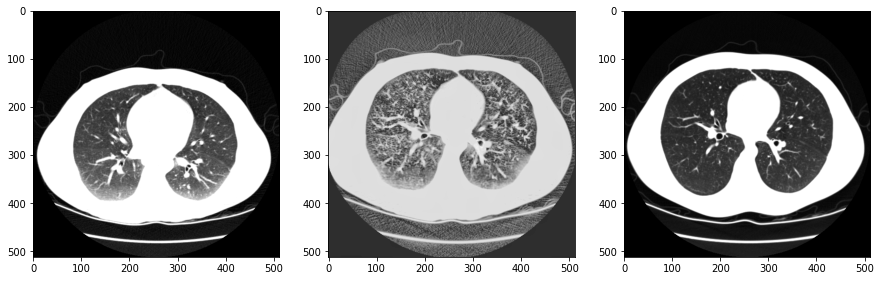

time: 14min 42s (started: 2022-12-20 09:28:25 +00:00)


In [ ]:
elx_filter = sitk.ElastixImageFilter()
elx_filter.SetFixedImage(i_nii_norm)
elx_filter.SetMovingImage(e_nii_norm)
elx_filter.SetFixedMask(i_seg_nii)
elx_filter.SetMovingMask(e_seg_nii)

## Parameter maps
param_map = sitk.ReadParameterFile(project_path + 'Par0011_bspline2.txt')
elx_filter.SetParameterMap(param_map)

## Execute
elx_filter.Execute()
reg_img = elx_filter.GetResultImage()
reg_img_np = sitk.GetArrayFromImage(reg_img)

## Plotting the moving, transformed and fixed image
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,12))
ax1.imshow(e_np_norm[60,:,:], cmap='gray')
ax2.imshow(reg_img_np[60,:,:], cmap='gray')
ax3.imshow(i_np_norm[60,:,:], cmap='gray')

## Transformation

### Prepare txt with inhale points

In [ ]:
columns = ['x','y','z']

array_i_1 = txt_to_np(patient_num, f'copd{patient_num}_300_iBH_xyz_r1')
df_i = pd.read_csv(project_path + f'copd{patient_num}/copd{patient_num}_300_iBH_xyz_r1.csv', header=None, names=columns)

## Writes a new txt file with the inhale points
with open(f'{project_path}copd{patient_num}/pts_i_{patient_num}.txt', 'w') as f:
    f.write('index\n')
    f.write('300\n')
    dfAsString = df_i.to_string(header=False, index=False)
    f.write(dfAsString)

time: 579 ms (started: 2022-12-20 09:43:08 +00:00)


### Transform the inhale points

In [ ]:
tfx_filter = sitk.TransformixImageFilter()
tfx_filter.SetTransformParameterMap(elx_filter.GetTransformParameterMap())
tfx_filter.SetMovingImage(i_nii)
tfx_filter.SetFixedPointSetFileName(f'{project_path}copd{patient_num}/pts_i_{patient_num}.txt')
tfx_filter.Execute()

## Writes a new txt file with the transformed points
df = pd.read_csv('outputpoints.txt', sep=';', header=None)
points_df = df.iloc[:,3]
points_df = points_df[:].str[21:32]

with open(f'{project_path}copd{patient_num}/pts_i_{patient_num}_REGISTERED.txt', 'w') as f:
    points_df = points_df.to_string(header=False, index=False)
    f.write(points_df)

time: 1min 12s (started: 2022-12-20 09:43:08 +00:00)


### Compute points distance with transformation

In [ ]:
# array_reg = txt_to_np(patient_num, f'pts_i_{patient_num}_REGISTERED')
# array_e = txt_to_np(patient_num, f'copd{patient_num}_300_eBH_xyz_r1')
# print(distance(array_reg, array_e, xy_spacing, z_spacing)[0])
# print(distance(array_reg, array_e, xy_spacing, z_spacing)[1])
# print('')

time: 465 µs (started: 2022-12-20 09:44:21 +00:00)


In [ ]:
sitk.WriteImage(reg_img, 'registered6.nii')

time: 297 ms (started: 2022-12-20 09:59:12 +00:00)
